# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



# Import library

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from google.colab import drive
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout



# load data

In [4]:
drive.mount('/content/drive')
PROJECT_ROOT_DIR = "/content/drive/MyDrive/"
data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data/tensorflow_data/')
os.makedirs(data_path, exist_ok=True)
print("Using directory: ", data_path)

Mounted at /content/drive
Using directory:  /content/drive/MyDrive/tensorflow_data/tensorflow_data/


In [5]:
flow_data_set_linear = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)

In [6]:
def make_df(data_set):
    df_list = []  # Create a list to hold DataFrames
    iter_data = iter(data_set['train'])

    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        video_frames = []

        for j in range(len(train_data['video'])):
            video_frames.append({'img': np.array(train_data['video'][j, :, :, :]),
                                 'y': train_data['instances']['category'].numpy()})

        df_list.append(pd.DataFrame(video_frames))

    return pd.concat(df_list, ignore_index=True)

# Create dataframes for each dataset
df_linear = make_df(flow_data_set_linear)  # 720 frames
df_fixed = make_df(flow_data_set_fixed)    # 720 frames
df_rot = make_df(flow_data_set_rotation)   # 720 frames

# Concatenate the dataframes into one dataframe
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  # 2160 frames


In [7]:
df.sample(5)

,img,y
1600,"[[[91, 101, 64], [81, 99, 37], [80, 112, 34], ...","[6, 16, 6]"
467,"[[[59, 72, 48], [56, 68, 48], [58, 68, 50], [5...",[6]
1861,"[[[91, 84, 92], [85, 78, 85], [94, 86, 92], [1...","[6, 14, 14]"
1800,"[[[124, 126, 124], [122, 124, 121], [121, 122,...",[6]
1275,"[[[200, 91, 53], [200, 93, 54], [201, 92, 54],...","[6, 16, 16]"


In [8]:
# datasets shapes
print(df_linear.shape)
print(df_fixed.shape)
print(df_rot.shape)

(720, 2)
(720, 2)
(720, 2)


# visualizing some examples

In [9]:
df_rot.sample(5)

,img,y
669,"[[[157, 167, 175], [149, 158, 167], [149, 159,...","[13, 13, 1]"
470,"[[[247, 204, 188], [247, 204, 188], [247, 204,...","[14, 13, 14]"
586,"[[[95, 107, 76], [95, 105, 76], [95, 101, 71],...","[14, 16, 13, 14, 16, 6, 13]"
493,"[[[135, 144, 158], [147, 157, 171], [145, 154,...","[6, 14, 3, 16, 6, 14]"
181,"[[[90, 74, 59], [95, 76, 59], [92, 74, 57], [9...",[1]


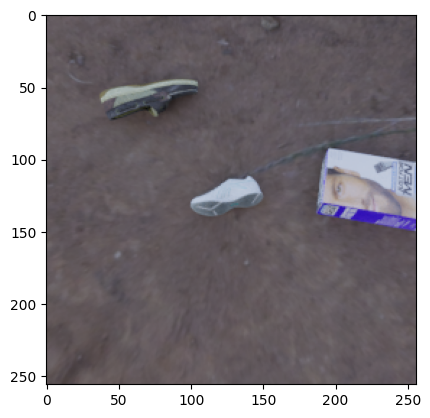

In [10]:
plt.imshow(np.array(df_rot['img'][426]))

# sample of data

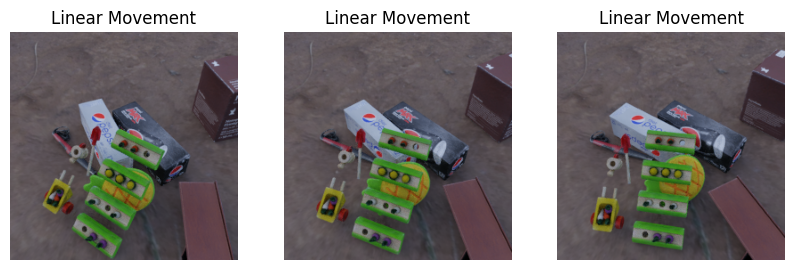

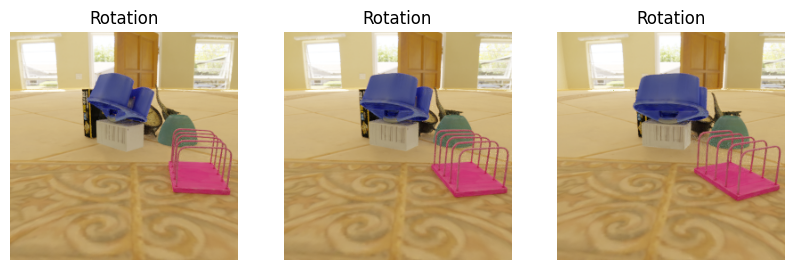

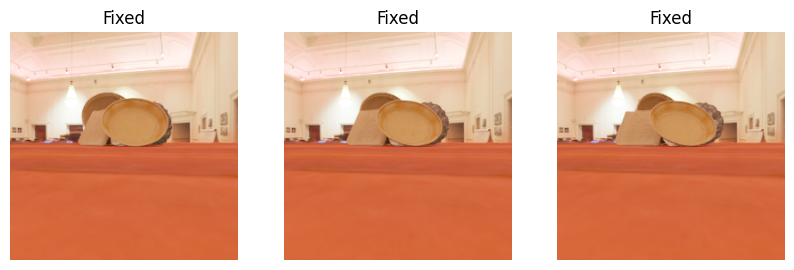

In [11]:
# in this section we will visualize the data by plotting some images from each dataset to see the difference between them

#linear move dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_linear['img'][0])
ax[0].set_title('Linear Movement')
ax[0].axis('off')
ax[1].imshow(df_linear['img'][1])
ax[1].set_title('Linear Movement')
ax[1].axis('off')
ax[2].imshow(df_linear['img'][2])
ax[2].set_title('Linear Movement')
ax[2].axis('off')
plt.show()

# rotation dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_rot['img'][0])
ax[0].set_title('Rotation')
ax[0].axis('off')
ax[1].imshow(df_rot['img'][1])
ax[1].set_title('Rotation')
ax[1].axis('off')
ax[2].imshow(df_rot['img'][2])
ax[2].set_title('Rotation')
ax[2].axis('off')
plt.show()


#fixed dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_fixed['img'][0])
ax[0].set_title('Fixed')
ax[0].axis('off')
ax[1].imshow(df_fixed['img'][1])
ax[1].set_title('Fixed')
ax[1].axis('off')
ax[2].imshow(df_fixed['img'][2])
ax[2].set_title('Fixed')
ax[2].axis('off')
plt.show()

In [12]:
# getting the most frequent class to classify based on it to gurantee data balance
from collections import Counter
Counter([item for sublist in df['y'] for item in sublist]).most_common(1)

[(14, 2208)]

# make a copy from the dataframe to keep the original one away from modification

In [13]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

In [14]:
df_copy.sample(5)

,img,y,z
1883,"[[[99, 132, 172], [99, 132, 172], [100, 132, 1...",[0],0
162,"[[[203, 175, 118], [202, 175, 122], [201, 173,...","[13, 6, 0]",0
1564,"[[[219, 179, 143], [219, 179, 143], [219, 179,...",[13],0
1603,"[[[91, 125, 15], [88, 128, 2], [91, 125, 15], ...","[6, 16, 6]",0
1978,"[[[199, 86, 51], [197, 84, 49], [197, 83, 47],...","[13, 6, 13, 6, 14, 16, 16]",1


## Now we should check for the data balance to avoid any problems that may appear due to data imbalance

Text(0.5, 1.0, 'Histogram of Shoe(1) vs. Non-Shoe(0)')

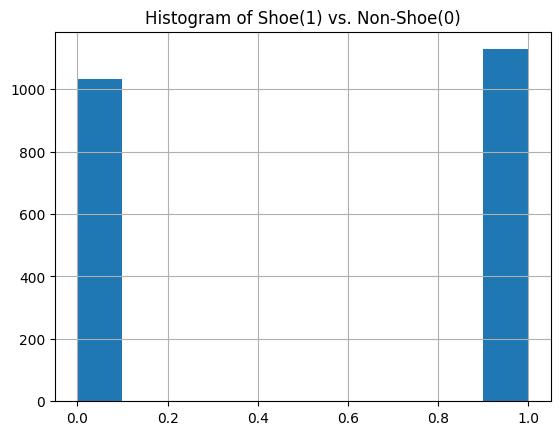

In [15]:
df_copy['z'].hist()
title = 'Histogram of Shoe(1) vs. Non-Shoe(0)'
plt.title(title)

## As we see the chosen class "shoe" (14) is a great choice for our binary classification problem

# Image preprocessing

In [16]:
# This function is used to preprocess the images by resizing them to 128x128,
# then enhancing them using unsharp mask, then denoising them

def preprocess_image(img, desired_size=(128, 128)):
    # Resizing
    img = resize(img, desired_size)

    # Enhancing the image using unsharp mask
    # img = unsharp_mask(img)

    # Denoising
    # sigma_est = np.mean(estimate_sigma(img))
    # img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True)

    # Histogram Equalization for enhancing contrast
    # img = equalize_hist(img)

    # Convert to grayscale
    # gray_img = rgb2gray(img)

    # Expand the dimensions to fit the model input shape
    return np.expand_dims(img, axis=-1)

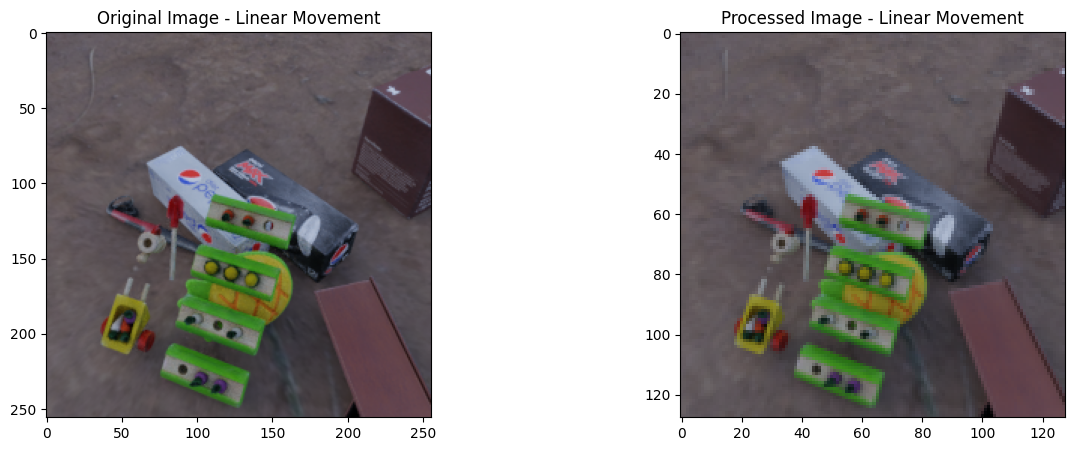

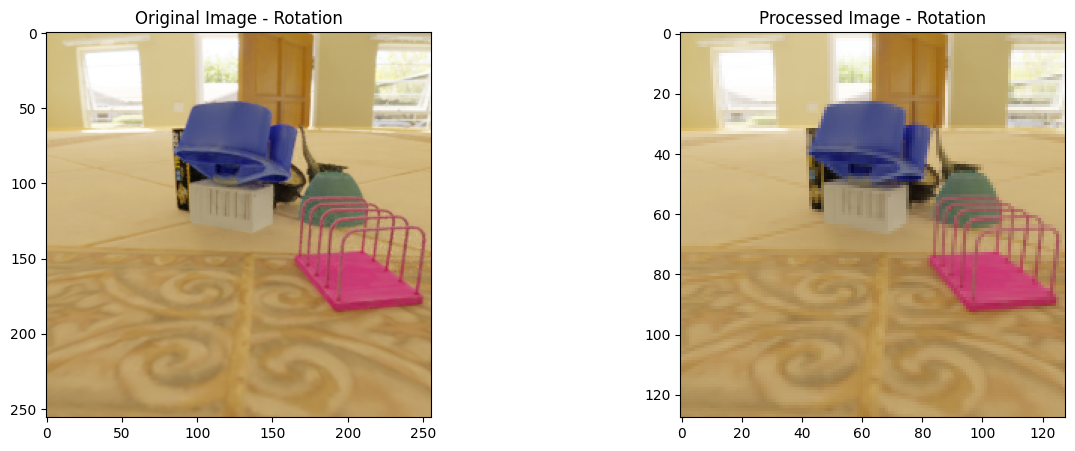

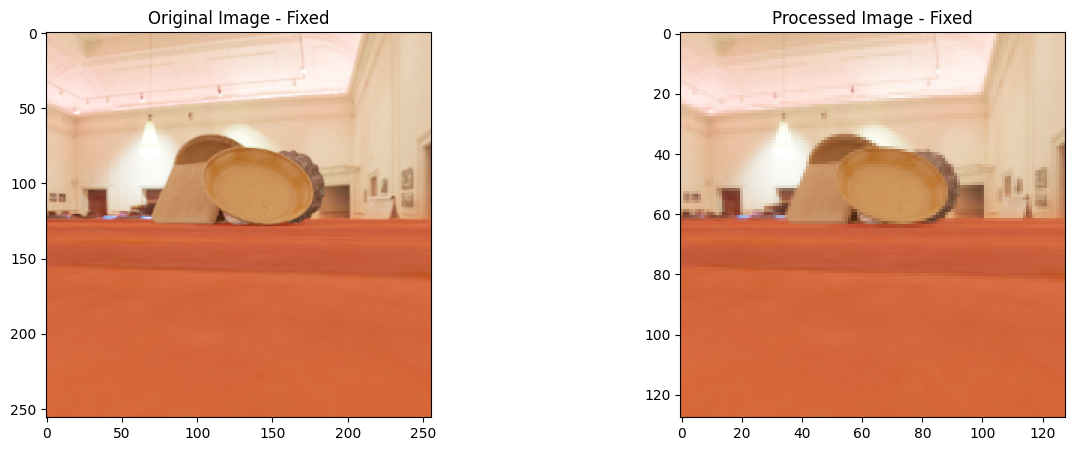

In [17]:
# this function is used to display the images before and after preprocessing
def display_image_processing(df, title):
      img = df['img'][1]
      processed_img = preprocess_image(img)
      fig, ax = plt.subplots(1, 2, figsize=(15, 5))
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image - {title}")
      ax[1].imshow(processed_img.squeeze(), cmap='gray')
      ax[1].set_title(f"Processed Image - {title}")
      plt.show()

# Display for each dataframe
display_image_processing(df_linear, 'Linear Movement')
display_image_processing(df_rot, 'Rotation')
display_image_processing(df_fixed, 'Fixed')

## Now the data is ready for the training step

In [19]:
df_copy_preprocess = copy.deepcopy(df_copy)

# Apply preprocessing to all images
df_copy_preprocess['img'] = df_copy_preprocess['img'].apply(preprocess_image)

In [20]:
train_data, temp_data = train_test_split(df_copy_preprocess, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Convert the list of processed images into an array
X_train = np.array(train_data['img'].tolist())
X_test = np.array(test_data['img'].tolist())
X_val = np.array(val_data['img'].tolist())

# Labels
y_train = train_data['z'].values
y_test = test_data['z'].values
y_val = val_data['z'].values

# Evaluation Functions

In [22]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = (model.predict(X_train) > 0.5).astype(int)
    train_cm = confusion_matrix(y_train, train_pred)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    val_cm = confusion_matrix(y_val, val_pred)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = (model.predict(X_test) > 0.5).astype(int)
    test_cm = confusion_matrix(y_test, test_pred)

    # Plotting Confusion Matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(train_cm, annot=True, cmap='Pastel2', ax=axs[0], fmt='g')
    axs[0].set_title('Training Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('Actual Labels')

    sns.heatmap(val_cm, annot=True, cmap='Pastel1', ax=axs[1], fmt='g')
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('Actual Labels')

    sns.heatmap(test_cm, annot=True, cmap='Pastel2', ax=axs[2], fmt='g')
    axs[2].set_title('Testing Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('Actual Labels')

    plt.tight_layout()
    plt.show()

In [23]:
def evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    def calculate_metrics(X, y):
        y_pred = model.predict(X)
        y_pred_classes = (y_pred > 0.5).astype(int)

        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes)
        loss = model.evaluate(X, y, verbose=0)[0]

        return accuracy, f1, loss, classification_report(y, y_pred_classes)

    train_accuracy, train_f1, train_loss, train_classification_report = calculate_metrics(X_train, y_train)
    val_accuracy, val_f1, val_loss, val_classification_report = calculate_metrics(X_val, y_val)
    test_accuracy, test_f1, test_loss, test_classification_report = calculate_metrics(X_test, y_test)

    results = {
        'Training': {
            'Accuracy': train_accuracy,
            'F1 Score': train_f1,
            'Loss': train_loss,
            'Classification Report': train_classification_report
        },
        'Validation': {
            'Accuracy': val_accuracy,
            'F1 Score': val_f1,
            'Loss': val_loss,
            'Classification Report': val_classification_report
        },
        'Test': {
            'Accuracy': test_accuracy,
            'F1 Score': test_f1,
            'Loss': test_loss,
            'Classification Report': test_classification_report
        }
    }

    return results


In [24]:
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Modeling

## ResNet50

ResNet50 is a powerful deep learning model for binary classification tasks. It comprises 50 layers of convolutional neural networks that allow for the extraction of intricate features from images. By utilizing skip connections, ResNet50 mitigates the vanishing gradient problem, enhancing training efficiency and enabling accurate classification between two classes.

In [25]:
def build_and_train_modelResNet50(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the base model using ResNet50
    input_tensor = Input(shape=(128, 128, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classifier layers
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Define the new model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=100,
        validation_data=(X_val, y_val),
        epochs=32
    )

    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = model.predict(X_test)
    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history


In [26]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history = build_and_train_modelResNet50(X_train, y_train, X_val, y_val, X_test, y_test)


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/32
16/16 [==============================] - 16s 184ms/step - loss: 1.4202 - accuracy: 0.4894 - val_loss: 0.9329 - val_accuracy: 0.4877
Epoch 2/32
16/16 [==============================] - 1s 57ms/step - loss: 0.7451 - accuracy: 0.5152 - val_loss: 0.6911 - val_accuracy: 0.5123
Epoch 3/32
16/16 [==============================] - 1s 68ms/step - loss: 0.6940 - accuracy: 0.4967 - val_loss: 0.6876 - val_accuracy: 0.4877
Epoch 4/32
16/16 [==============================] - 1s 57ms/step - loss: 0.6814 - accuracy: 0.5311 - val_loss: 0.6868 - val_accuracy: 0.4877
Epoch 5/32
16/16 [==============================] - 1s 57ms/step - loss: 0.6773 - accuracy: 0.5337 - val_loss: 0.6771 - val_accuracy: 0.4846
Epoch 6/32
16/16 [==============================] - 1s 67ms/step - loss: 0.6731 - accuracy: 0.6138 - val_loss: 0.6772 - val_accuracy: 0.4877
Epoch 7/32
16/16 [==============================] - 1s 68ms/step - loss: 0.6691 - accur

11/11 [==============================] - 0s 16ms/step


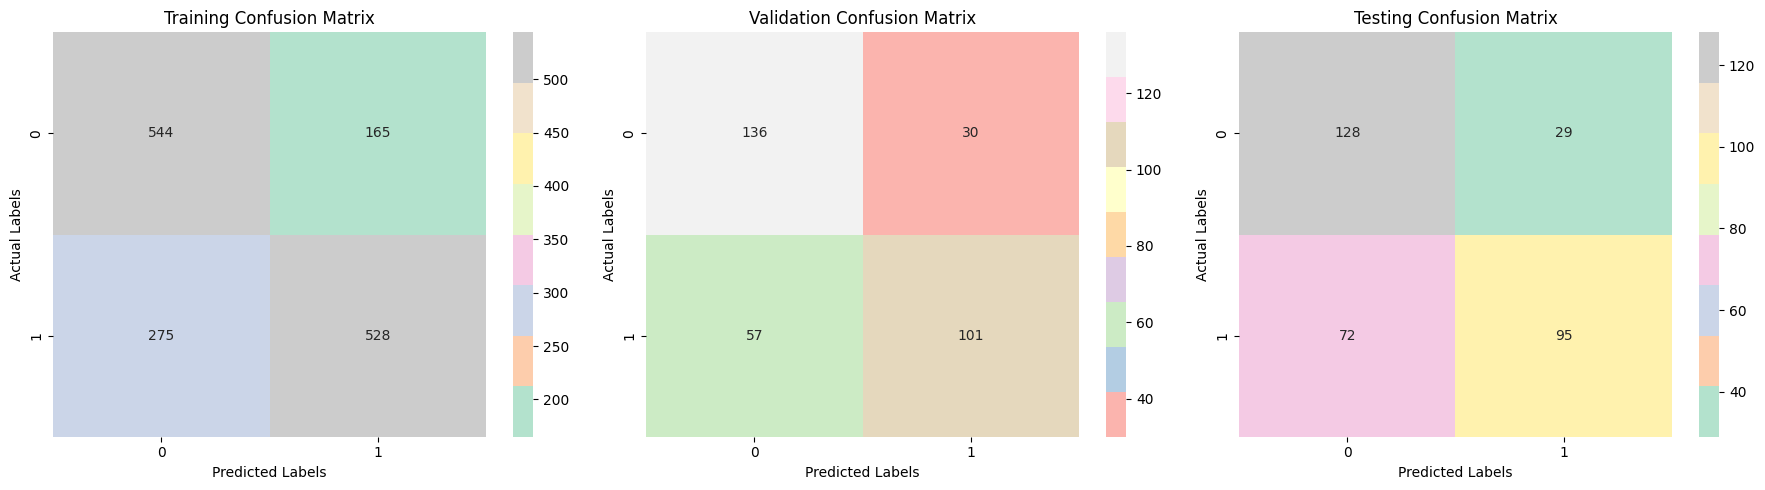

11/11 [==============================] - 0s 17ms/step
Training Set:
Accuracy: 0.708994708994709
F1 Score: 0.7058823529411765
Loss: 0.5313172936439514
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       709
           1       0.76      0.66      0.71       803

    accuracy                           0.71      1512
   macro avg       0.71      0.71      0.71      1512
weighted avg       0.72      0.71      0.71      1512



Validation Set:
Accuracy: 0.7314814814814815
F1 Score: 0.6989619377162629
Loss: 0.526419997215271
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       166
           1       0.77      0.64      0.70       158

    accuracy                           0.73       324
   macro avg       0.74      0.73      0.73       324
weighted avg       0.74      0.73      0.73       324



Test Set:
Accuracy: 0.6882716049382716
F1 Score:

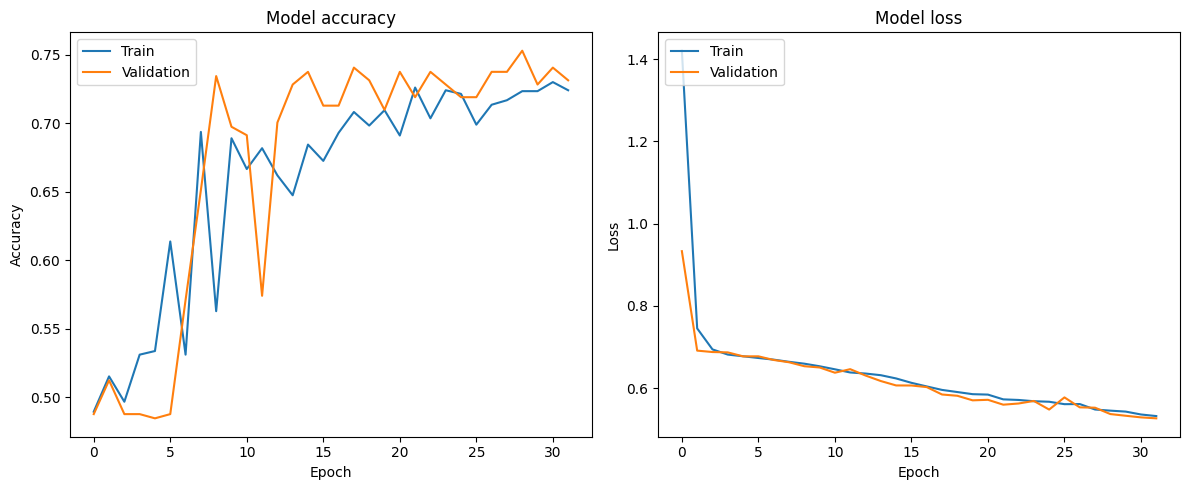

In [27]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history)

## Inception



The Inception model for binary classification utilizes a deep learning architecture called InceptionV3. It extracts features from images through multiple convolutional layers and employs global average pooling for dimensionality reduction. Dropout layers help prevent overfitting, while dense layers and a final sigmoid activation function produce binary classification results. This model is effective for tasks like distinguishing between two classes in images.

In [29]:
def build_and_train_inception_model(X_train, y_train, X_val, y_val, X_test, y_test):
    # Define the base model using InceptionV3
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout added
    predictions = Dense(1, activation='sigmoid')(x)
    InceptionV3model = Model(inputs=base_model.input, outputs=predictions)

    InceptionV3model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Train the model with early stopping
    history_InceptionV3model = InceptionV3model.fit(X_train, y_train, epochs=32, batch_size=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate the model on train, validation, and test sets
    train_loss, train_accuracy = InceptionV3model.evaluate(X_train, y_train, verbose=0)
    y_train_pred = InceptionV3model.predict(X_train)
    train_cm = confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = InceptionV3model.evaluate(X_val, y_val, verbose=0)
    y_val_pred = InceptionV3model.predict(X_val)
    val_cm = confusion_matrix(y_val, y_val_pred > 0.5)

    test_loss, test_accuracy = InceptionV3model.evaluate(X_test, y_test, verbose=0)
    y_test_pred = InceptionV3model.predict(X_test)
    test_cm = confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionV3model, history_InceptionV3model


In [30]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionV3model, history_InceptionV3model = build_and_train_inception_model(X_train, y_train, X_val, y_val, X_test, y_test)


87910968/87910968 [==============================] - 3s 0us/step


Epoch 1/32
16/16 [==============================] - 46s 435ms/step - loss: 0.4066 - accuracy: 0.8095 - val_loss: 5335.9771 - val_accuracy: 0.4877
Epoch 2/32
16/16 [==============================] - 2s 106ms/step - loss: 0.1556 - accuracy: 0.9821 - val_loss: 834127.1250 - val_accuracy: 0.4877
Epoch 3/32
16/16 [==============================] - 2s 106ms/step - loss: 0.0372 - accuracy: 0.9940 - val_loss: 41346.8086 - val_accuracy: 0.4877
Epoch 4/32
16/16 [==============================] - 2s 105ms/step - loss: 0.0671 - accuracy: 0.9775 - val_loss: 37948.1836 - val_accuracy: 0.4877
Epoch 5/32
16/16 [==============================] - 2s 105ms/step - loss: 0.1591 - accuracy: 0.9590 - val_loss: 2191517.7500 - val_accuracy: 0.4877
Epoch 6/32
16/16 [==============================] - 2s 120ms/step - loss: 0.0942 - accuracy: 0.9709 - val_loss: 17285184.0000 - val_accuracy: 0.4877
Epoch 6: early stopping
11/11 [==============================] - 0s 16ms/step


11/11 [==============================] - 0s 16ms/step


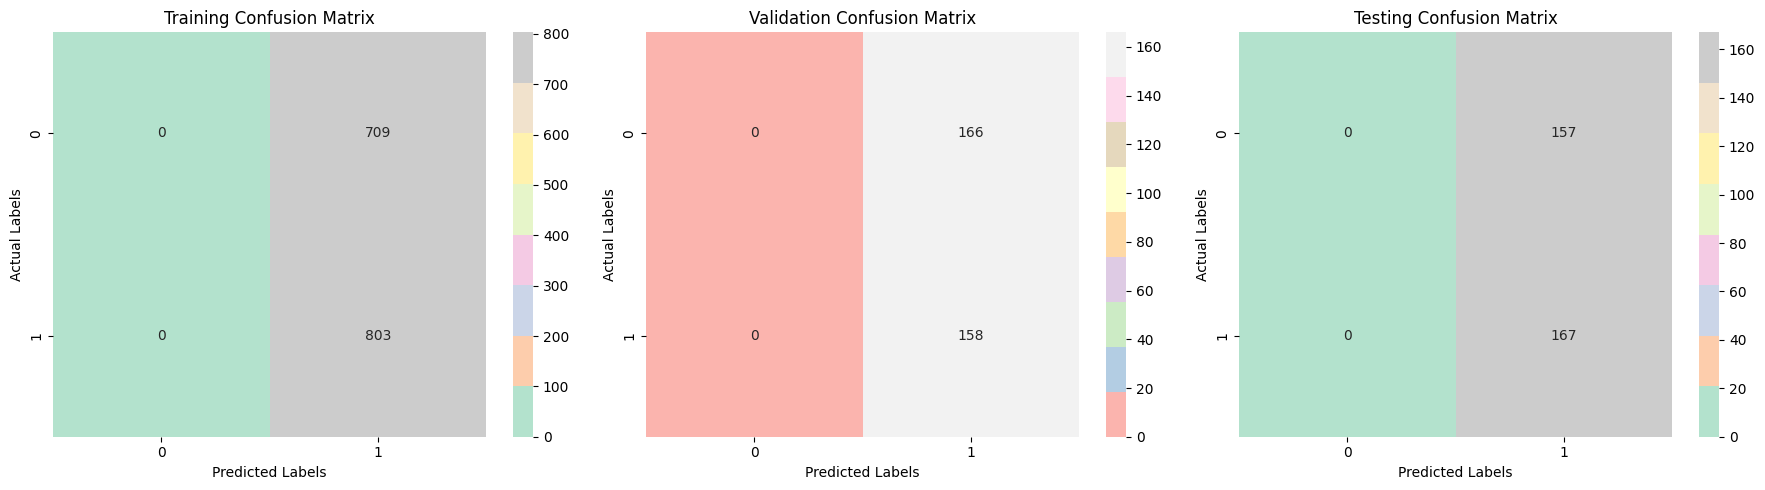

48/48 [==============================] - 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


11/11 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Set:
Accuracy: 0.531084656084656
F1 Score: 0.6937365010799136
Loss: 5738.3974609375
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       709
           1       0.53      1.00      0.69       803

    accuracy                           0.53      1512
   macro avg       0.27      0.50      0.35      1512
weighted avg       0.28      0.53      0.37      1512



Validation Set:
Accuracy: 0.4876543209876543
F1 Score: 0.6556016597510373
Loss: 5335.97119140625
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       166
           1       0.49      1.00      0.66       158

    accuracy                           0.49       324
   macro avg       0.24      0.50      0.33       324
weighted avg       0.24      0.49      0.32       324



Test Set:
Accuracy: 0.5154320987654321
F1 Score: 0.6802443991853361
Loss: 7176.62890625
Classification Rep

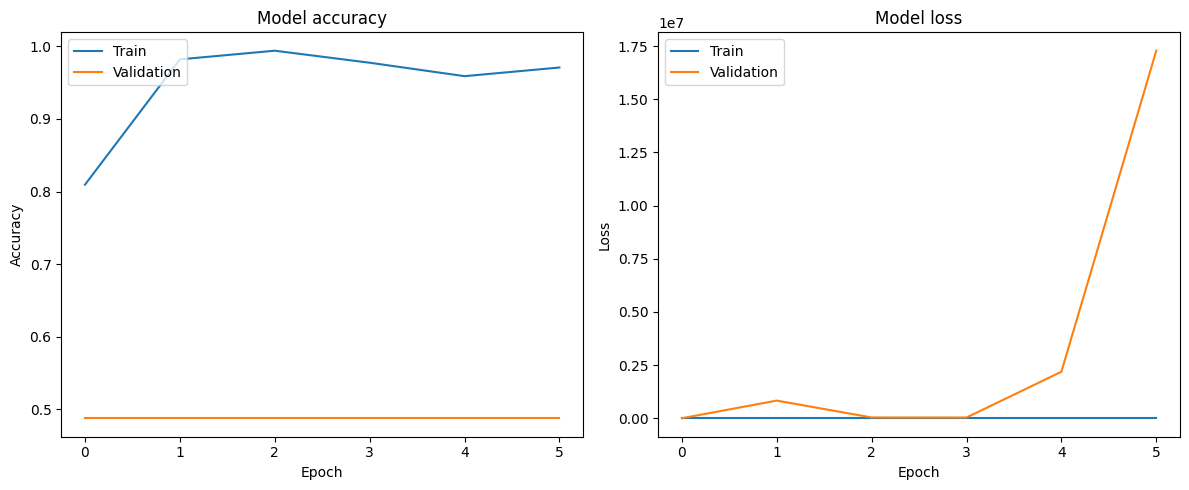

In [31]:
evaluate_model(InceptionV3model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(InceptionV3model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_InceptionV3model)

## InceptionResNetV2

The InceptionResNetV2_Model function is intended for image classification tasks using the InceptionResNetV2 architecture. It takes in training, validation, and test data along with a pre-initialized InceptionResNetV2 model. The function then configures the model with an Adam optimizer using a binary cross-entropy loss function and accuracy as the metric. It fits the model to the provided training data for a specified number of epochs, utilizing the validation data for validation during training.

The function computes various evaluation metrics such as loss, accuracy, and confusion matrix for the training, validation, and test sets. Finally, it returns these evaluation metrics along with the trained model for further analysis.

In [32]:
def build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the Inception-ResNetV2 model
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    InceptionResNetV2model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    InceptionResNetV2model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history_InceptionResNetV2 = InceptionResNetV2model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))

    # Evaluate the model on training data
    train_loss, train_accuracy = InceptionResNetV2model.evaluate(X_train, y_train)
    y_train_pred = InceptionResNetV2model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    # Evaluate the model on validation data
    val_loss, val_accuracy = InceptionResNetV2model.evaluate(X_val, y_val)
    y_val_pred = InceptionResNetV2model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    # Evaluate the model on test data
    test_loss, test_accuracy = InceptionResNetV2model.evaluate(X_test, y_test)
    y_test_pred = InceptionResNetV2model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionResNetV2model, history_InceptionResNetV2


In [33]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, InceptionResNetV2model, history_InceptionResNetV2 = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)


219055592/219055592 [==============================] - 7s 0us/step
Epoch 1/32
48/48 [==============================] - 22s 166ms/step - loss: 0.7848 - accuracy: 0.6382 - val_loss: 0.3857 - val_accuracy: 0.8241
Epoch 2/32
48/48 [==============================] - 5s 101ms/step - loss: 0.4580 - accuracy: 0.8022 - val_loss: 0.3011 - val_accuracy: 0.9074
Epoch 3/32
48/48 [==============================] - 4s 83ms/step - loss: 0.3626 - accuracy: 0.8472 - val_loss: 0.2791 - val_accuracy: 0.9136
Epoch 4/32
48/48 [==============================] - 6s 124ms/step - loss: 0.2746 - accuracy: 0.8922 - val_loss: 0.2356 - val_accuracy: 0.9537
Epoch 5/32
48/48 [==============================] - 5s 100ms/step - loss: 0.2061 - accuracy: 0.9332 - val_loss: 0.1960 - val_accuracy: 0.9537
Epoch 6/32
48/48 [==============================] - 4s 75ms/step - loss: 0.1854 - accuracy: 0.9345 - val_loss: 0.1754 - val_accuracy: 0.9568
Epoch 7/32
48/48 [==============================] - 6s 128ms/step - loss: 0.1561 -

11/11 [==============================] - 1s 50ms/step


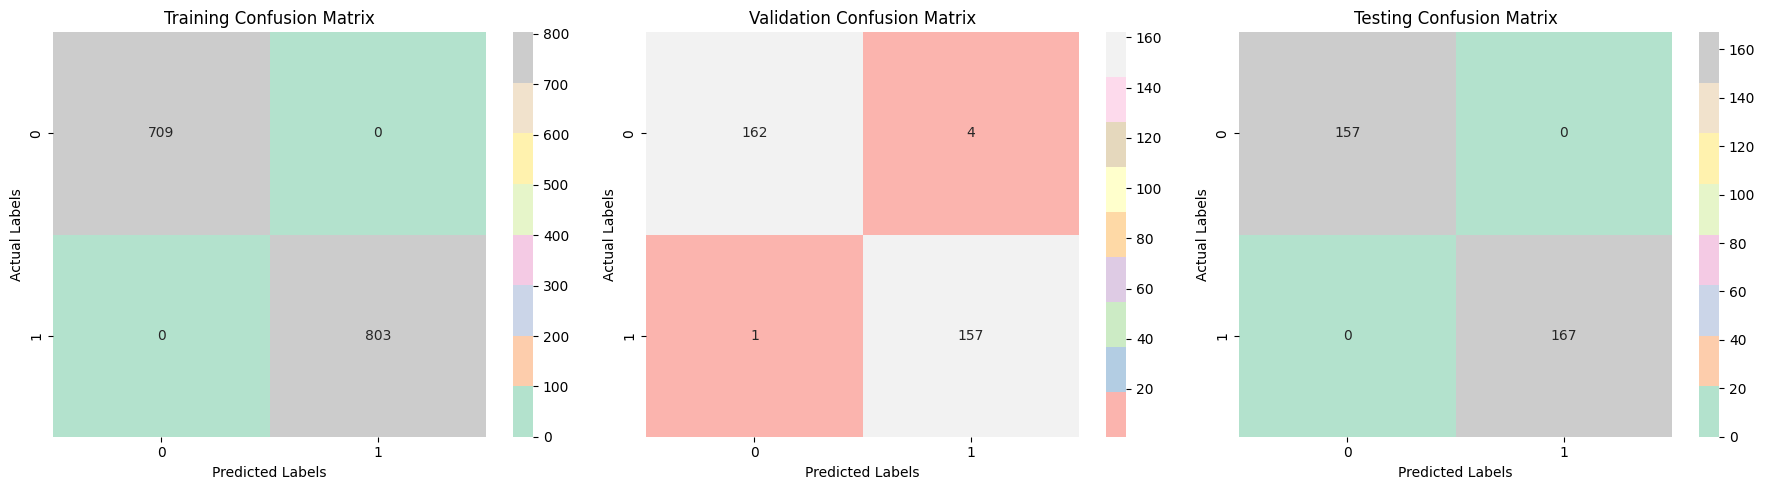

11/11 [==============================] - 1s 72ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.007076564710587263
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       709
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



Validation Set:
Accuracy: 0.9845679012345679
F1 Score: 0.9843260188087773
Loss: 0.05965077877044678
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       166
           1       0.98      0.99      0.98       158

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324



Test Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.023302054032683372
Classifi

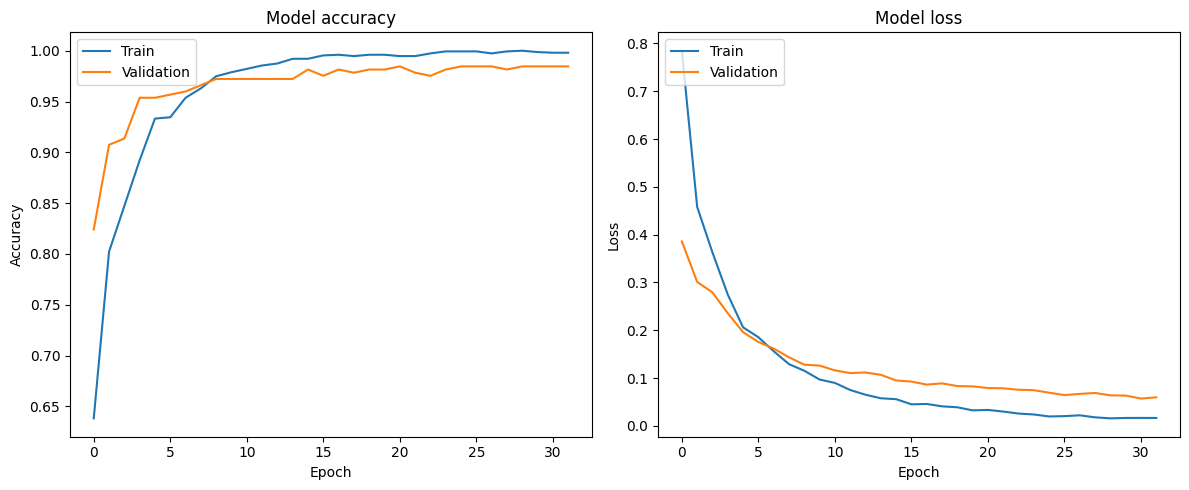

In [34]:
evaluate_model(InceptionResNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(InceptionResNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_InceptionResNetV2)

## MobileNetV2

MobileNetV2 is a lightweight deep learning model designed for efficient deployment on resource-constrained devices like mobile phones and embedded systems. It leverages depth-wise separable convolutions to reduce computational complexity while maintaining high accuracy in image recognition tasks. This architecture allows MobileNetV2 to achieve state-of-the-art performance on various tasks, making it a popular choice for mobile applications requiring real-time image processing. Its compact size and impressive performance make it a versatile option for a wide range of computer vision applications on devices with limited computational resources.

In [35]:
def build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    MobileNetV2model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    MobileNetV2model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history_MobileNetV2 = MobileNetV2model.fit(X_train, y_train, epochs=32, validation_data=(X_val, y_val))

    # Evaluate the model
    train_loss, train_accuracy = MobileNetV2model.evaluate(X_train, y_train)
    y_train_pred = MobileNetV2model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = MobileNetV2model.evaluate(X_val, y_val)
    y_val_pred = MobileNetV2model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    test_loss, test_accuracy = MobileNetV2model.evaluate(X_test, y_test)
    y_test_pred = MobileNetV2model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, MobileNetV2model, history_MobileNetV2

In [36]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, MobileNetV2model, history_MobileNetV2 = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)


Epoch 1/32
48/48 [==============================] - 35s 260ms/step - loss: 0.8155 - accuracy: 0.6310 - val_loss: 0.3735 - val_accuracy: 0.8611
Epoch 2/32
48/48 [==============================] - 3s 56ms/step - loss: 0.4294 - accuracy: 0.8056 - val_loss: 0.3010 - val_accuracy: 0.9043
Epoch 3/32
48/48 [==============================] - 5s 105ms/step - loss: 0.3303 - accuracy: 0.8644 - val_loss: 0.2593 - val_accuracy: 0.9259
Epoch 4/32
48/48 [==============================] - 6s 127ms/step - loss: 0.2823 - accuracy: 0.8836 - val_loss: 0.2243 - val_accuracy: 0.9383
Epoch 5/32
48/48 [==============================] - 3s 52ms/step - loss: 0.2175 - accuracy: 0.9299 - val_loss: 0.2009 - val_accuracy: 0.9630
Epoch 6/32
48/48 [==============================] - 3s 53ms/step - loss: 0.1889 - accuracy: 0.9372 - val_loss: 0.1789 - val_accuracy: 0.9691
Epoch 7/32
48/48 [==============================] - 3s 57ms/step - loss: 0.1562 - accuracy: 0.9504 - val_loss: 0.1651 - val_accuracy: 0.9691
Epoch 8/3

11/11 [==============================] - 0s 33ms/step


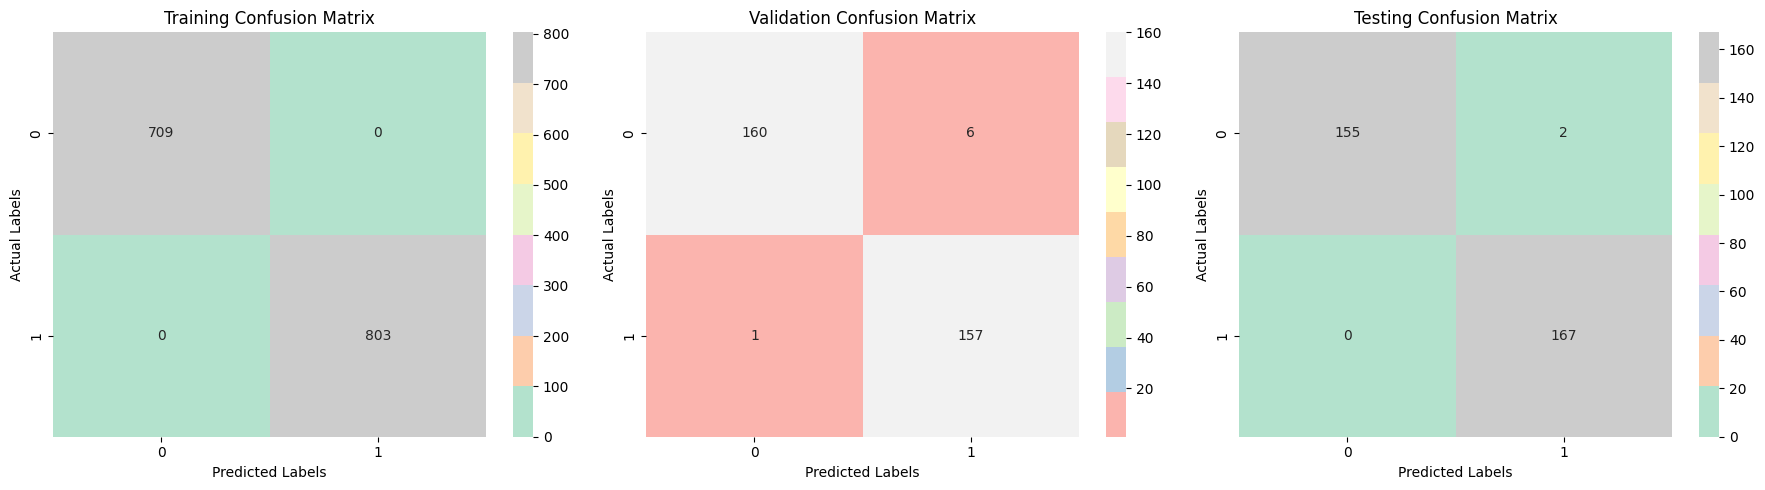

11/11 [==============================] - 0s 34ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.007025932427495718
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       709
           1       1.00      1.00      1.00       803

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



Validation Set:
Accuracy: 0.9783950617283951
F1 Score: 0.9781931464174455
Loss: 0.07682009041309357
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       166
           1       0.96      0.99      0.98       158

    accuracy                           0.98       324
   macro avg       0.98      0.98      0.98       324
weighted avg       0.98      0.98      0.98       324



Test Set:
Accuracy: 0.9938271604938271
F1 Score: 0.9940476190476192
Loss:

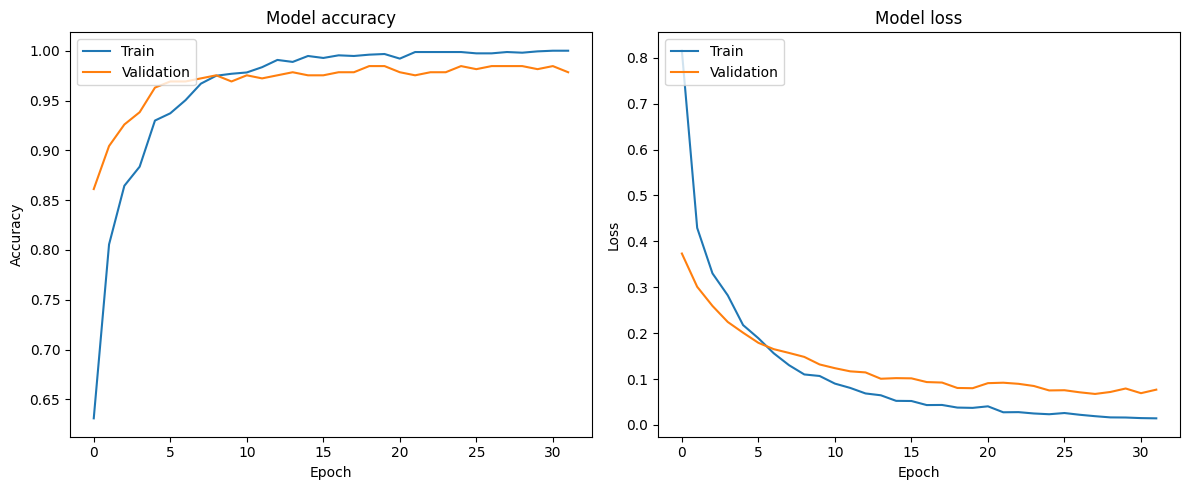

In [37]:
evaluate_model(MobileNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(MobileNetV2model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

plot_learning_curves(history_MobileNetV2)

## Yolo v8

YOLO (You Only Look Once) v8 is a state-of-the-art binary classification model. It uses a single pass through the network to simultaneously detect and classify objects. YOLO v8 achieves exceptional speed and accuracy by dividing the image into a grid, predicting bounding boxes and class probabilities. This allows for real-time performance in applications like object recognition.

In [ ]:
import os

# Define the base directory path
base_dir = "E:/OneDrive - University of Ottawa/CV/CV Project/Data"
test_dir = "E:\OneDrive - University of Ottawa\CV\CV Project\Data test"

In [ ]:
# from PIL import Image

# # Function to save images in the specified directory
# def save_images(data, split_type):
#     for index, row in data.iterrows():
#         img_array = row['img']
#         class_label = row['z']

#         class_name = 'Shoe' if class_label == 1 else 'No_Shoe'

#         if split_type == 'test':
#             image_filename = f"{class_name}_{index}.jpg"
#             image_path = os.path.join(test_dir, split_type, class_name, image_filename)
#         else:
#             image_filename = f"{class_name}_{index}.jpg"
#             image_path = os.path.join(base_dir, split_type, class_name, image_filename)

#         image_filename = f"{class_name}_{index}.jpg"
#         image_path = os.path.join(base_dir, split_type, class_name, image_filename)

#         image = Image.fromarray(img_array)
#         image.save(image_path)

# # Save images for train, validation,z and test sets
# save_images(train_data, 'train')
# save_images(val_data, 'val')
# save_images(test_data, 'test')

In [ ]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=base_dir, epochs=2, imgsz=128)  # train the model

New https://pypi.org/project/ultralytics/8.0.207 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.181  Python-3.11.5 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10700 2.90GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=E:/OneDrive - University of Ottawa/CV/CV Project/Data, epochs=2, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=Non

In [ ]:
def plot_confusion_matrix(TP, TN, FP, FN):
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Shoe", "No Shoe"], rotation=45)
    plt.yticks(tick_marks, ["Shoe", "No Shoe"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="white" if i == j else "black")

    plt.tight_layout()
    plt.show()

In [ ]:
# Load a model
# model = YOLO('yolov8n-cls.pt')  # load an official model
model = YOLO(r"E:\OneDrive - University of Ottawa\CV\CV Project\PreProcess\runs\classify\train6\weights\best.pt")  # load a custom model

# Predict with the model
shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data test\test\Shoe")  # predict on an image
no_shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data test\test\No_Shoe")  # predict on an image

In [ ]:
counts=[]
for result in shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts.append(index)
TP = counts.count(1)
FN = counts.count(0)

counts1=[]
for result in no_shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts1.append(index)
TN = counts1.count(0)
FP = counts1.count(1)

confusion_matrix_data = [[TN, FP], [FN, TP]]

print("TP:",TP)
print("FP:",FP)
print("TN:",TN)
print("FN:",FN)

TP: 166
FP: 0
TN: 157
FN: 1


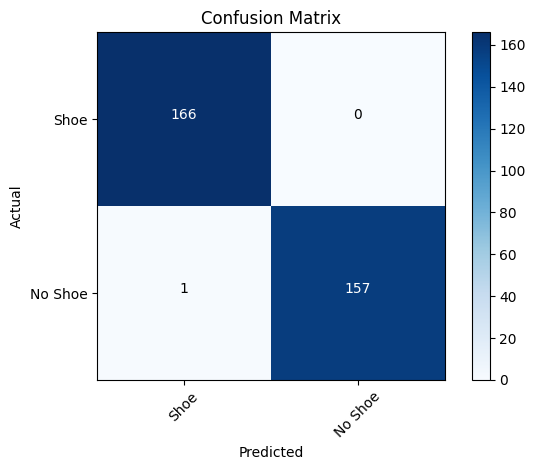

Test Accuracy: 0.9969135802469136
Test Recall: 0.9940119760479041
Test Precision: 1.0
Test F1-score: 0.996996996996997


In [ ]:
plot_confusion_matrix(TP, TN, FP, FN)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate Recall
recall = TP / (TP + FN)

# Calculate F1-Score
f1 = (2 * precision * recall) / (precision + recall)

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)
print("Test Precision:", precision)
print("Test F1-score:", f1)